<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>

# Vector Representations
## *Data Science Unit 4 Sprint 2 Assignment 2*

In [1]:
import re
import string

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import spacy

from bs4 import BeautifulSoup

In [2]:
def count(docs):

        word_counts = Counter()
        appears_in = Counter()
        
        total_docs = len(docs)

        for doc in docs:
            word_counts.update(doc)
            appears_in.update(set(doc))

        temp = zip(word_counts.keys(), word_counts.values())
        
        wc = pd.DataFrame(temp, columns = ['word', 'count'])

        wc['rank'] = wc['count'].rank(method='first', ascending=False)
        total = wc['count'].sum()

        wc['pct_total'] = wc['count'].apply(lambda x: x / total)
        
        wc = wc.sort_values(by='rank')
        wc['cul_pct_total'] = wc['pct_total'].cumsum()

        t2 = zip(appears_in.keys(), appears_in.values())
        ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
        wc = ac.merge(wc, on='word')

        wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)
        
        return wc.sort_values(by='rank')

## 1) *Clean:* Job Listings from indeed.com that contain the title "Data Scientist" 

You have `job_listings.csv` in the data folder for this module. The text data in the description column is still messy - full of html tags. Use the [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) library to clean up this column. You will need to read through the documentation to accomplish this task. 

In [3]:
from bs4 import BeautifulSoup
import requests
import pandas as pd

df = pd.read_csv('./data/job_listings.csv')

In [4]:
# def clean_description(desc):
#     soup = BeautifulSoup(desc)
#     return soup.get_text()
# df['clean_desc'] = df['description'].apply(clean_description)

In [7]:
19
def remove_html(df):
    df = df.copy()
    df['description'] = df['description'].apply(lambda x: BeautifulSoup(x).get_text().replace("\\n", " "))
    df['description'] = df['description'].str.replace('b"', '')
    df['description'] = df['description'].apply(lambda x: re.sub('[0-9]+', '', x))
    df['description'] = df['description'].str.lower()
    df['tokenized'] = df['description'].apply(lambda x: [token.text for token in nlp(x) 
                                                         if not token.is_stop])
    return df

In [9]:
from spacy.tokenizer import Tokenizer

nlp = spacy.load("en_core_web_lg")

# Tokenizer
tokenizer = Tokenizer(nlp.vocab)

In [13]:
df = remove_html(df)

In [14]:
df.head()

,Unnamed: 0,description,title,clean_desc,tokenized
0,0,job requirements: conceptual understanding in ...,Data scientist,"b""Job Requirements:\nConceptual understanding ...","[job, requirements, :, conceptual, understandi..."
1,1,"b'job description as a data scientist , you w...",Data Scientist I,"b'Job Description\n\nAs a Data Scientist 1, yo...","[b'job, description, , data, scientist, ,, he..."
2,2,b'as a data scientist you will be working on c...,Data Scientist - Entry Level,b'As a Data Scientist you will be working on c...,"[b'as, data, scientist, working, consulting, b..."
3,3,"b'$, - $, a monthcontractunder the general sup...",Data Scientist,"b'$4,969 - $6,756 a monthContractUnder the gen...","[b'$, ,, -, $, ,, monthcontractunder, general,..."
4,4,b'location: usa \xe\x\x multiple locations + y...,Data Scientist,b'Location: USA \xe2\x80\x93 multiple location...,"[b'location, :, usa, \xe\x\x, multiple, locati..."


## 2) Use Spacy to tokenize the listings 

In [38]:
#creating a column with tokenized description
tokens = []

for doc in tokenizer.pipe(df['description'], batch_size=500):
    
    doc_tokens = []
    
    for token in doc:
        if (token.is_stop == False) & (token.is_punct == False):
            doc_tokens.append(token.text.lower())

    tokens.append(doc_tokens)

df['tokens'] = tokens

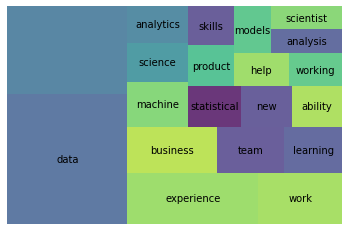

In [40]:
# Plotting
import squarify
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
wc = count(df['tokens'])

wc_top20 = wc[wc['rank'] <= 20]

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

## 3) Use Scikit-Learn's CountVectorizer to get word counts for each listing.

In [32]:
# create the transformer
vect = CountVectorizer(stop_words='english', max_features=1000)

In [33]:
# Learning the vocab
vect.fit(df['clean_desc'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=1000, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words='english',
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

## 4) Visualize the most common word counts

In [41]:
# Get sparse Document Term Matrices (DTM)
dtm = vect.transform(df['description'])

dtm = pd.DataFrame(dtm.todense(), columns=vect.get_feature_names())
dtm.head()

,000,10,100,2019,40,abilities,ability,able,academic,access,...,xa6,xae,xb7,xbb,xc2,xe2,xef,year,years,york
0,0,0,0,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


## 5) Use Scikit-Learn's tfidfVectorizer to get a TF-IDF feature matrix

In [35]:
def tokenize(document):
    
    doc = nlp(document)
    
    return [token.lemma_.strip() for token in doc if (token.is_stop != True) and (token.is_punct != True)]

In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Instantiate vectorizer object
tfidf = TfidfVectorizer(stop_words='english', 
                        ngram_range=(1,2),
                        max_df=.97,
                        min_df=3,
                        tokenizer=tokenize)

# Create a vocabulary and get word counts per document
# Similiar to fit_predict
dtm = tfidf.fit_transform(df['description'])

# Print word counts

# Get feature names to use as dataframe column headers
dtm = pd.DataFrame(dtm.todense(), columns=tfidf.get_feature_names())

# View Feature Matrix as DataFrame
dtm.head()

,,,+,\xc\xbb,\xef\x\x,ability,addition,additional,advanced,amazon,...,you\xe\x\xre,you\xe\x\xre data,you\xe\x\xre look,you\xe\x\xre ready,you\xe\x\xve,you\xe\x\xve work,yrs,|,||,~
0,0.028866,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.065194,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.029014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.059715,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 6) Create a NearestNeighbor Model. Write the description of your ideal datascience job and query your job listings. 

In [43]:
from sklearn.neighbors import NearestNeighbors

# Fit on DTM
nn = NearestNeighbors(n_neighbors=5, algorithm='kd_tree')
nn.fit(dtm)

NearestNeighbors(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [44]:
nn.kneighbors([dtm.iloc[0].values])

(array([[0.        , 1.31593199, 1.31640529, 1.32758969, 1.33136005]]),
 array([[  0, 115, 274, 168, 366]], dtype=int64))

In [45]:
dream_job = [ """
Sleep!
"""]

In [46]:
# Query for Sim of Random doc to BBC
new = tfidf.transform(dream_job)

In [47]:
nn.kneighbors(new.todense())

(array([[1.23232905, 1.28464267, 1.31337236, 1.33212657, 1.33319654]]),
 array([[288, 396, 215, 299, 199]], dtype=int64))

In [50]:
df['description'][288]

'the data scientist will work autonomously and under general supervision of the program director and director of biostatistics within the program of sleep medicine epidemiology in the division of sleep and circadian disorders. the primary role of the data scientist will be to lead the design, analysis and interpretation of large data sets from a variety of projects, including clinical trials, genetic epidemiological studies and cohort studies. analyses will include use of state-of-the-art machine learning methods as well as standard basic and advanced epidemiological and biostatistical tools. the data scientist will be responsible for ensuring that the most appropriate method(s) are chosen for given scientific objectives; data are processed and organized to support these analyses; output/results are interpreted appropriately; and data reports are prepared for use by a wide audience. the data scientist will develop analysis pipelines and open source packages (r, python), and will work u

## Stretch Goals

 - Try different visualizations for words and frequencies - what story do you want to tell with the data?
 - Scrape Job Listings for the job title "Data Analyst". How do these differ from Data Scientist Job Listings
 - Try and identify requirements for experience specific technologies that are asked for in the job listings. How are those distributed among the job listings?
 - Use a clustering algorithm to cluster documents by their most important terms. Do the clusters reveal any common themes?
  - **Hint:** K-means might not be the best algorithm for this. Do a little bit of research to see what might be good for this. Also, remember that algorithms that depend on Euclidean distance break down with high dimensional data.
 - Create a labeled dataset - which jobs will you apply for? Train a model to select the jobs you are most likely to apply for. :) 